# PINN for RC circuit with physics loss 
### Decomment 2nd block of code for consistent initialising seed
### Network trained with dataset used ***without DataLoader***

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv 
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import random


In [2]:
# Initialise random seed for model weights and activations

"""def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # If using torch.backends (optional for CPU, more relevant for CUDA)
    if torch.backends.mps.is_available():
        torch.use_deterministic_algorithms(True)

set_seed(42)"""

'def set_seed(seed=42):\n    torch.manual_seed(seed)\n    np.random.seed(seed)\n    random.seed(seed)\n\n    # If using torch.backends (optional for CPU, more relevant for CUDA)\n    if torch.backends.mps.is_available():\n        torch.use_deterministic_algorithms(True)\n\nset_seed(42)'

In [3]:
df = pd.read_csv("rc_dataset_2000.csv")
#print(df)
print(df.shape)

(2000, 6)


In [4]:

# Data normalisation

X = df[["R", "C", "Vin"]].values
Y = df[["V_out"]].values

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_tensor = torch.tensor(scaler_x.fit_transform(X), dtype = torch.float32)
Y_tensor = torch.tensor(scaler_y.fit_transform(Y), dtype = torch.float32)

#print(X_tensor[:,0])
#print(Y_tensor)

dataset = TensorDataset(X_tensor, Y_tensor)

#loader = DataLoader(dataset, batch_size=32, shuffle=True)

R = X_tensor[:,0]
C = X_tensor[:,1]
print(R)
print(C)

print((R*C).shape)

tensor([-0.8704, -0.8704, -0.8704,  ...,  1.5667,  1.5667,  1.5667])
tensor([0.1741, 0.1741, 0.1741,  ..., 1.5667, 1.5667, 1.5667])
torch.Size([2000])


In [5]:
class RegressionModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 8)
        self.fc6 = nn.Linear(8, 1)
        


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # No activation on output for regression
        return x

In [6]:
in_features = 3
out_features = 1


model = RegressionModel(in_features, out_features)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


## The differential equation that controls our physics loss 

## ⚙️ Differential Equation of an RC Circuit (Time Domain)

The first-order differential equation for the voltage across a capacitor in an RC circuit is:

$$
u(t) + RC \cdot \frac{du(t)}{dt} = U
$$

Where:
- \( u(t) \) is the output voltage (e.g. across the capacitor),
- \( R \) is the resistance (Ω),
- \( C \) is the capacitance (F),
- \( U \) is the constant input voltage.

This equation describes the dynamic response of the voltage in the circuit over time.


In [7]:
# Function to compute the PDE residual: 

def pde_residual(model, x):
    # Make sure x is set to require gradients for derivative calculations.
    x = x.clone().detach().requires_grad_(True)
    u = model(x)
    
    # Compute the first derivative, du/dx.
    u_x = (torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0])[:,0]
    
    """print(u_x.shape)
    print(x.shape)
    print(u[:,0].shape)"""

    R = x[:, 0]
    C = x[:, 1]
    U = x[:, 2]

    """print(R.shape)
    print(C.shape)
    print(U.shape)"""
    
    residual = u[:,0] + R*C*u_x - U

    return residual


pde_test = pde_residual(model, X_tensor)
print(pde_test)
print(pde_test.shape)



tensor([ 1.9324,  1.7589,  1.5853,  ..., -1.0085, -1.1821, -1.3585],
       grad_fn=<SubBackward0>)
torch.Size([2000])


Epoch [1], Loss: 2.164486885
Epoch [2], Loss: 2.157999039
Epoch [3], Loss: 2.151602745
Epoch [4], Loss: 2.145346642
Epoch [5], Loss: 2.139071703
Epoch [6], Loss: 2.132795334
Epoch [7], Loss: 2.126537800
Epoch [8], Loss: 2.120338917
Epoch [9], Loss: 2.114177704
Epoch [10], Loss: 2.107871056
Epoch [11], Loss: 2.101411343
Epoch [12], Loss: 2.094728231
Epoch [13], Loss: 2.087910652
Epoch [14], Loss: 2.080870390
Epoch [15], Loss: 2.073620796
Epoch [16], Loss: 2.066185951
Epoch [17], Loss: 2.058666468
Epoch [18], Loss: 2.050973177
Epoch [19], Loss: 2.043165445
Epoch [20], Loss: 2.035115719
Epoch [21], Loss: 2.026818514
Epoch [22], Loss: 2.018241167
Epoch [23], Loss: 2.009203434
Epoch [24], Loss: 1.999836445
Epoch [25], Loss: 1.989955783
Epoch [26], Loss: 1.979571104
Epoch [27], Loss: 1.968615770
Epoch [28], Loss: 1.957226872
Epoch [29], Loss: 1.945183158
Epoch [30], Loss: 1.932538629
Epoch [31], Loss: 1.919159412
Epoch [32], Loss: 1.904998779
Epoch [33], Loss: 1.890050888
Epoch [34], Loss: 1

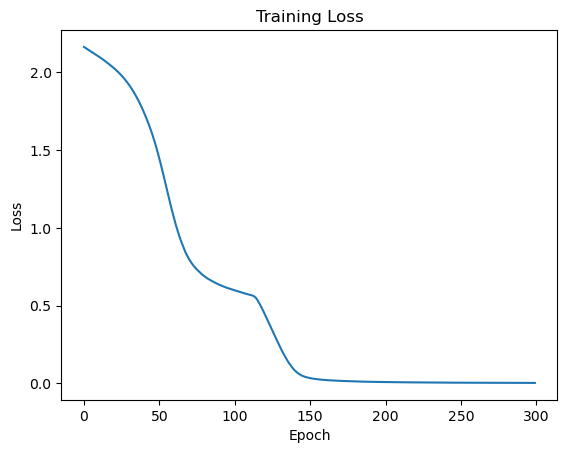

In [8]:
nb_epochs = 300
losses = []
# Before training
#set_seed(42)
model.train()
for i in range(nb_epochs):
    """for X_batch, Y_batch in loader:
        
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()"""
    

    # Physics loss
    res = pde_residual(model, X_tensor)
    loss_physics = torch.mean(res**2)

    # MSE loss
    outputs = model(X_tensor)
    loss_mse = criterion(outputs, Y_tensor) 

    # final loss
    loss = loss_mse + loss_physics

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())


    print(f'Epoch [{i+ 1}], Loss: {loss.item():.9f}')

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
   

In [9]:
model.eval()

# No gradient calculation during evaluation
with torch.no_grad():
    # Forward pass
    predictions = model(X_tensor)  # Assuming X_tensor is your input data

    # Calculate the loss (optional)
    loss = criterion(predictions, Y_tensor)
    print(f"Evaluation Loss: {loss.item():.3f}")

    predictions_original = scaler_y.inverse_transform(predictions.numpy())

    # Print the inverse transformed predictions
    print("Inverse Predictions: \n", predictions_original)

Evaluation Loss: 0.001
Inverse Predictions: 
 [[0.16855316]
 [0.67884   ]
 [1.1839161 ]
 ...
 [9.092087  ]
 [9.474103  ]
 [9.672613  ]]


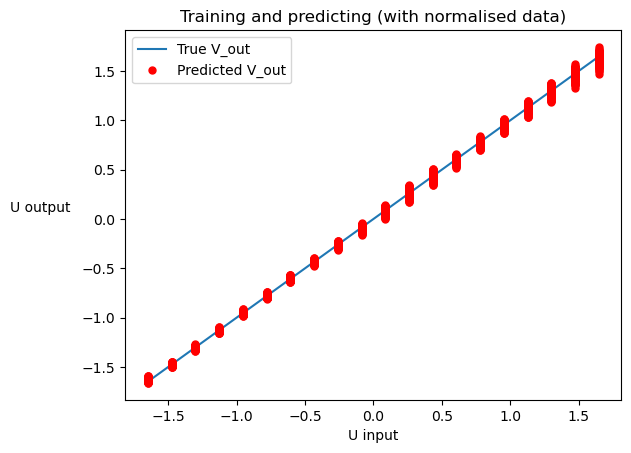

In [16]:
plt.title("Training and predicting (with normalised data)")
plt.plot(X_tensor[:,2], Y_tensor[:,0], label = "True V_out")
plt.xlabel("U input")
plt.ylabel("U output", rotation = 0, labelpad=30)
plt.plot(X_tensor[:,2], predictions[:,0], label = "Predicted V_out", color='red', linestyle='None', marker='o', markersize=5)
plt.legend()


plt.show()

In [11]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
"""print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])"""



Model's state_dict:
fc1.weight 	 torch.Size([8, 3])
fc1.bias 	 torch.Size([8])
fc2.weight 	 torch.Size([16, 8])
fc2.bias 	 torch.Size([16])
fc3.weight 	 torch.Size([64, 16])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([32, 64])
fc4.bias 	 torch.Size([32])
fc5.weight 	 torch.Size([8, 32])
fc5.bias 	 torch.Size([8])
fc6.weight 	 torch.Size([1, 8])
fc6.bias 	 torch.Size([1])


'print("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])'

In [ ]:
# Defining model name and save the model

name = "My_model"    # À changer selon l'utilisateur
torch.save(model.state_dict(), name)

# Load the saved model and evaluate

my_model = RegressionModel(in_features, out_features)
my_model.load_state_dict(torch.load(name, weights_only=True))
my_model.eval()


with torch.no_grad():
    # Forward pass
    predictions = my_model(X_tensor)  

    # Calculate the loss (optional)
    loss = criterion(predictions, Y_tensor)
    print(f"Evaluation Loss: {loss.item():.3f}")

Evaluation Loss: 0.001
